In [89]:
import pandas as pd
from collections import OrderedDict
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math 

import numpy as np

In [2]:
PAST_TIME_RANGE = 24  # use 24 past timeframe
FUTURE_TIME_RANGE = 6  # predict 6 timeframe

In [3]:
data = pd.read_csv("wikipedia.csv", index_col="timestamp")

In [4]:
data.head()

,views
timestamp,
2016-01-01 00:00:00,0.617284
2016-01-01 01:00:00,0.041002
2016-01-01 02:00:00,-0.581760
2016-01-01 03:00:00,-1.025069
2016-01-01 04:00:00,-1.291514


In [5]:
df = OrderedDict()
for i in range(PAST_TIME_RANGE):
    col_name = "T-{}".format(i)
    series = data.views.shift(i)
    df[col_name] = series
for i in range(1,FUTURE_TIME_RANGE+1):
    col_name = "T+{}".format(i)
    series = data.views.shift(-i)
    df[col_name] = series
data_set = pd.DataFrame(df, index=data.index).dropna()
data_set.head()

,T-0,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9,...,T-20,T-21,T-22,T-23,T+1,T+2,T+3,T+4,T+5,T+6
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 23:00:00,0.898701,2.292393,3.798601,3.302904,1.769037,2.001836,1.445126,1.372633,1.309160,1.565804,...,-1.025069,-0.581760,0.041002,0.617284,0.113880,-0.547334,-0.905009,-1.132992,-1.258555,-1.311624
2016-01-02 00:00:00,0.113880,0.898701,2.292393,3.798601,3.302904,1.769037,2.001836,1.445126,1.372633,1.309160,...,-1.291514,-1.025069,-0.581760,0.041002,-0.547334,-0.905009,-1.132992,-1.258555,-1.311624,-1.219801
2016-01-02 01:00:00,-0.547334,0.113880,0.898701,2.292393,3.798601,3.302904,1.769037,2.001836,1.445126,1.372633,...,-1.395559,-1.291514,-1.025069,-0.581760,-0.905009,-1.132992,-1.258555,-1.311624,-1.219801,-0.935167
2016-01-02 02:00:00,-0.905009,-0.547334,0.113880,0.898701,2.292393,3.798601,3.302904,1.769037,2.001836,1.445126,...,-1.380255,-1.395559,-1.291514,-1.025069,-1.132992,-1.258555,-1.311624,-1.219801,-0.935167,-0.475324
2016-01-02 03:00:00,-1.132992,-0.905009,-0.547334,0.113880,0.898701,2.292393,3.798601,3.302904,1.769037,2.001836,...,-1.233514,-1.380255,-1.395559,-1.291514,-1.258555,-1.311624,-1.219801,-0.935167,-0.475324,-0.013263


In [6]:
X = data_set[[c for c in data_set.columns if "-" in c]]
Y = data_set[[c for c in data_set.columns if "+" in c]]
X.shape, Y.shape

((4971, 24), (4971, 6))

In [7]:
limit_train_test = round(0.75 * len(X))
x_train, x_test = X[:limit_train_test].values, X[limit_train_test:].values
y_train, y_test = Y[:limit_train_test].values, Y[limit_train_test:].values
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3728, 24), (1243, 24), (3728, 6), (1243, 6))

In [216]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv1d(1, 16, 5, padding=2)
        self.cnn16 = nn.Conv1d(16, 16, 5, padding=2)
        self.cnn_stride = nn.Conv1d(16, 16, 5, padding=2, stride=2)
        self.deconv1 = nn.ConvTranspose1d(16*12, 16, 3)
        self.deconv2 = nn.ConvTranspose1d(16, 16, 3)
        self.deconv3 = nn.ConvTranspose1d(16, 1, 3)
        self.relu = nn.ReLU()
        self.batchNorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, input, train=True):
        output = self.cnn1(input.view(input.data.shape[0], 1, input.data.shape[1]))
        output = self.batchNorm(output)
        output = self.relu(output)
        output = self.cnn16(output)
        output = self.relu(output)
        output = self.cnn16(output)
        output = self.relu(output)
        
        output = self.cnn_stride(output)
        
        output = self.relu(output)
        output = self.cnn16(output)
        output = self.relu(output)
        output = self.cnn16(output)
        output = self.relu(output)
        
#         if train:
#             output = self.dropout(output)
        
        output = self.deconv1(output.view(output.data.shape[0], -1, 1))
        output = self.batchNorm(output)
        output = self.relu(output)
        output = self.deconv2(output)
        output = self.relu(output)
        output = self.deconv3(output)[:,:,:-1]
        return output

In [217]:
if type(x_train) != torch.DoubleTensor:
    x_train = torch.from_numpy(x_train)
    y_train = torch.from_numpy(y_train)
    x_test = torch.from_numpy(x_test)
    y_test = torch.from_numpy(y_test)

model = Model().cuda()
optimized = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimized, patience=5, verbose=True)
criterion = nn.MSELoss()

best_mse = 999
early_stop_counter = 0
for epoch in range(256):
    MSE_train = np.zeros(math.ceil(x_train.shape[0]/16))
    MSE_test = np.zeros(math.ceil(x_test.shape[0]/16))

    for i in range(0, x_train.shape[0], 16):
        x_train_batch, y_train_batch = Variable(x_train[i:i+16]).float().cuda(), Variable(y_train[i:i+16]).float().cuda()
        pred = model.forward(x_train_batch)
        loss = criterion(pred, y_train_batch)
        
        MSE_train[int(i//16)] = loss.data[0]
        
        optimized.zero_grad()
        loss.backward()
        optimized.step()

    # compute MSE for test
    for i in range(0, x_test.shape[0], 16):
        x_test_batch, y_test_batch = Variable(x_test[i:i+16]).float().cuda(), Variable(y_test[i:i+16]).float().cuda()
        pred = model.forward(x_test_batch, train=False)
        loss = criterion(pred, y_test_batch)
        MSE_test[int(i//16)] = loss.data[0]
    
    scheduler.step(MSE_test.mean())
    
    if MSE_test.mean() < best_mse:
        best_mse = MSE_test.mean()
        early_stop_counter = 0
    else:
        early_stop_counter +=1

    print("Epoch {} : Train {:.4} \t Test {:.4} \t Best MSE {:.4}".format(epoch, MSE_train.mean(), MSE_test.mean(), best_mse))
    if early_stop_counter > 10:
        print("early stopped")
        break
    

Epoch 0 : Train 0.4273 	 Test 0.1063 	 Best MSE 0.1063
Epoch 1 : Train 0.1142 	 Test 0.0901 	 Best MSE 0.0901
Epoch 2 : Train 0.09596 	 Test 0.08311 	 Best MSE 0.08311
Epoch 3 : Train 0.07519 	 Test 0.07279 	 Best MSE 0.07279
Epoch 4 : Train 0.05714 	 Test 0.06576 	 Best MSE 0.06576
Epoch 5 : Train 0.04717 	 Test 0.05901 	 Best MSE 0.05901
Epoch 6 : Train 0.04118 	 Test 0.05481 	 Best MSE 0.05481
Epoch 7 : Train 0.0367 	 Test 0.05378 	 Best MSE 0.05378
Epoch 8 : Train 0.03346 	 Test 0.05444 	 Best MSE 0.05378
Epoch 9 : Train 0.03089 	 Test 0.05474 	 Best MSE 0.05378
Epoch 10 : Train 0.02953 	 Test 0.05395 	 Best MSE 0.05378
Epoch 11 : Train 0.02816 	 Test 0.05225 	 Best MSE 0.05225
Epoch 12 : Train 0.02694 	 Test 0.0525 	 Best MSE 0.05225
Epoch 13 : Train 0.02614 	 Test 0.05127 	 Best MSE 0.05127
Epoch 14 : Train 0.02515 	 Test 0.05183 	 Best MSE 0.05127
Epoch 15 : Train 0.02455 	 Test 0.05122 	 Best MSE 0.05122
Epoch 16 : Train 0.02392 	 Test 0.05193 	 Best MSE 0.05122
Epoch 17 : Trai

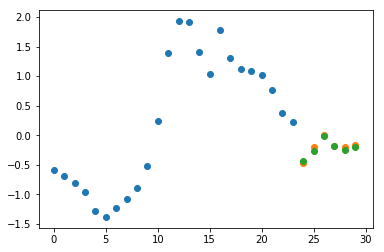

In [218]:
i = 25
x = Variable(x_test[i:i+16]).float().cuda()
y = Variable(y_test[i:i+16]).float().cuda()
pred = model.forward(x)

plt.figure()
plt.scatter(range(24), x.data[0].cpu().numpy())
plt.scatter(range(24, 24+6), y.data[0].cpu().numpy())
plt.scatter(range(24, 24+6), pred.data[0].cpu().numpy())
plt.show()